# Unicycle Navigation with Invariant Set Control

An invariant set in control theory is a region in state space where, once the system enters, it remains confined for all future time steps. Mathematically, for a dynamical system with state $x_t$ and dynamics function $f$:

$S \text{ is invariant if } x_t \in S \implies x_{t+1} = f(x_t) \in S \text{ for all } t \geq 0$

## Computing Invariance in the Unicycle Navigation System

### 1. Reachable Set Computation

For each time step $t$, we compute over-approximated reachable sets $R_t = [l_t, u_t]$ where:
- $l_t$ is a lower bound vector
- $u_t$ is an upper bound vector
- The reachable set is a hyperrectangle guaranteed to contain all possible states

### 2. Invariant Set Identification

After allowing for initial transient behavior (until step $k$), we compute the invariant set $S$ as the intersection of all subsequent reachable sets:

$S = \bigcap_{t \geq k} R_t$

In practice, this intersection is computed as:
- Lower bound: $l_S = \max_{t \geq k} l_t$
- Upper bound: $u_S = \min_{t \geq k} u_t$

The set $S = [l_S, u_S]$ is invariant if it's non-empty ($l_S \leq u_S$) and maps into itself under the dynamics.

### 3. Training for Invariance

The neural network controller is trained with a specialized loss function that includes an invariance penalty:

$L = L_{base} + \lambda_{inv} \cdot L_{inv}$

where $L_{inv}$ penalizes differences between consecutive reachable set bounds:

$L_{inv} = \sum_{t=k}^{T-1} (||l_t - l_{t+1}|| + ||u_t - u_{t+1}||)$

Additionally, we enforce that the final reachable set maps back into itself:

$L_{final} = ||l_T - l_{T+1}|| + ||u_T - u_{T+1}||$

For neural network controllers, which are typically considered "black boxes," establishing invariant properties bridges the gap between learning-based control and formal verification.

In [1]:
!pip install git+https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git@newer-jax-verify

  Cloning https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git (to revision newer-jax-verify) to /tmp/pip-req-build-xf2w88_m
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git /tmp/pip-req-build-xf2w88_m
  Running command git checkout -b newer-jax-verify --track origin/newer-jax-verify
  Switched to a new branch 'newer-jax-verify'
  Branch 'newer-jax-verify' set up to track remote branch 'newer-jax-verify' from 'origin'.
  Resolved https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git to commit e3128f4da97353ade04bb5637277339d41687461
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/deepmind/einshape.git to /tmp/pip-install-gx_krksz/einshape_2cf7499ebd824815b69ada9c3193e601
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/einshape.git /tmp/pip-install-gx_krksz/einshape_2cf7499ebd824815b69ada9c3193e601
  Resolved https://github.com/d

In [2]:
import jax
import jax.numpy as jnp
from typing import List, Callable
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import jax_verify
import functools
import optax
from jax import grad, jit
import time
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Neural Network Controller

In [3]:
def relu_nn(params, inputs, v_max=7, omega_max=np.pi):
    for W, b in params[:-1]:
        outputs = jnp.dot(inputs, W) + b
        inputs = jnp.maximum(outputs, 0)
    Wout, bout = params[-1]
    outputs = jnp.dot(inputs, Wout) + bout

    v = jnp.clip(outputs[0], -v_max, v_max)
    omega = jnp.clip(outputs[1], -omega_max, omega_max)

    return jnp.array([v, omega])

def init_network_params(layer_sizes, rng_key):
    params = []
    for i in range(1, len(layer_sizes)):
        in_dim = layer_sizes[i - 1]
        out_dim = layer_sizes[i]
        key, rng_key = jax.random.split(rng_key)
        bound = jnp.sqrt(6.0 / (in_dim + out_dim))
        weights = jax.random.uniform(key, (in_dim, out_dim), minval=-bound, maxval=bound)
        biases = jnp.zeros(out_dim)
        params.append((weights, biases))
    return params

# Initialize neural network parameters
layer_sizes = [3, 16, 32, 16, 2]
rng_key = jax.random.PRNGKey(0)
params = init_network_params(layer_sizes, rng_key)

# Unicycle Model

In [4]:
class UnicycleModel:
    def __init__(self):
        self.delta_t = 0.1

    def dynamics_step(self, xs, ut):
        x, y, theta = xs
        v, omega = ut

        theta_new = theta + omega * self.delta_t

        x_new = x + v * jnp.cos(theta) * self.delta_t
        y_new = y + v * jnp.sin(theta) * self.delta_t

        return jnp.array([x_new, y_new, theta_new])

dyn = UnicycleModel()

#  Visualization Functions

In [5]:
def plot_loss_history(loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_with_invariant_subset(initial_state_range, step_fn, num_steps, cost_map,
                              invariant_x_min, invariant_x_max, invariant_y_min, invariant_y_max,
                              bounds_list=None, invariance_start_step=22):
    xt = np.random.uniform(low=initial_state_range[:, 0], high=initial_state_range[:, 1], size=(1000, 3))
    states = [xt]

    for _ in range(num_steps):
        xt1 = jax.vmap(step_fn)(xt)
        states.append(xt1)
        xt = xt1

    plt.figure(figsize=(14, 10))

    all_x = np.concatenate([state[:, 0] for state in states])
    all_y = np.concatenate([state[:, 1] for state in states])
    x_min, x_max = np.min(all_x), np.max(all_x)
    y_min, y_max = np.min(all_y), np.max(all_y)

    x_padding = (x_max - x_min) * 0.1
    y_padding = (y_max - y_min) * 0.1
    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)

    ax = plt.gca()
    ax.set_facecolor('white')

    if bounds_list is not None:
        for i, bounds in enumerate(bounds_list):
            lower = bounds.lower
            upper = bounds.upper

            color = plt.cm.plasma(i / len(bounds_list))
            alpha = 0.5 - (0.3 * i / len(bounds_list))

            rect = Rectangle((lower[0], lower[1]),
                            upper[0] - lower[0],
                            upper[1] - lower[1],
                            fill=True,
                            facecolor=color,
                            edgecolor='black',
                            linewidth=1,
                            alpha=alpha,
                            zorder=1)
            plt.gca().add_patch(rect)

    if invariant_x_min is not None and invariant_y_min is not None:
        invariant_width = invariant_x_max - invariant_x_min
        invariant_height = invariant_y_max - invariant_y_min

        outline_rect = Rectangle((invariant_x_min, invariant_y_min),
                                invariant_width, invariant_height,
                                fill=False,
                                edgecolor='red',
                                linewidth=3.5,
                                linestyle='solid',
                                zorder=25)
        plt.gca().add_patch(outline_rect)

        dashed_outline = Rectangle((invariant_x_min, invariant_y_min),
                                 invariant_width, invariant_height,
                                 fill=False,
                                 edgecolor='white',
                                 linewidth=2.5,
                                 linestyle='dashed',
                                 zorder=24)
        plt.gca().add_patch(dashed_outline)

        invariant_rect = Rectangle((invariant_x_min, invariant_y_min),
                                  invariant_width, invariant_height,
                                  fill=True,
                                  facecolor='lime',
                                  alpha=0.5,
                                  zorder=6,
                                  label='Invariant Subset')
        plt.gca().add_patch(invariant_rect)

        plt.text((invariant_x_min + invariant_x_max)/2, (invariant_y_min + invariant_y_max)/2,
                'INVARIANT',
                ha='center', va='center',
                color='black', fontweight='bold', fontsize=14,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3', edgecolor='black'),
                zorder=26)

    distinct_colors = []
    tab_colors = plt.cm.tab20(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors)

    tab_colors_b = plt.cm.tab20b(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors_b)

    tab_colors_c = plt.cm.tab20c(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors_c)

    for i, state in enumerate(states):
        color = distinct_colors[i % len(distinct_colors)]

        plt.scatter(state[:, 0], state[:, 1], s=7, color=color, alpha=0.8,
                   label=f'Step {i}' if i % 3 == 0 or i == len(states)-1 else None,
                   zorder=10,
                   edgecolors='black', linewidths=0.3)

    init_x_mid = (initial_state_range[0, 0] + initial_state_range[0, 1]) / 2
    init_y_mid = (initial_state_range[1, 0] + initial_state_range[1, 1]) / 2
    init_width = initial_state_range[0, 1] - initial_state_range[0, 0]
    init_height = initial_state_range[1, 1] - initial_state_range[1, 0]

    init_rect = Rectangle((initial_state_range[0, 0], initial_state_range[1, 0]),
                         init_width, init_height,
                         fill=True, facecolor='red', edgecolor='black',
                         linewidth=2, alpha=0.3, zorder=5)
    plt.gca().add_patch(init_rect)
    plt.text(init_x_mid, init_y_mid, 'START',
             ha='center', va='center',
             color='white', fontweight='bold', fontsize=18,
             bbox=dict(facecolor='red', alpha=0.7, boxstyle='round,pad=0.5'),
             zorder=15)

    goal_zone = np.unravel_index(np.argmin(cost_map), cost_map.shape)
    goal_y, goal_x = goal_zone
    plt.scatter(goal_x, goal_y, s=400, marker='*', color='gold',
               edgecolor='black', linewidth=1.5, zorder=20)
    plt.text(goal_x, goal_y + 0.5, 'GOAL',
             ha='center', va='center',
             color='black', fontweight='bold', fontsize=18,
             bbox=dict(facecolor='green', alpha=0.7, boxstyle='round,pad=0.5'),
             zorder=20)

    plt.xlabel('X Position', fontsize=20)
    plt.ylabel('Y Position', fontsize=20)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.grid(True, linestyle='--', alpha=0.6, zorder=0)

    step_handles = []

    legend_elements = [
        *step_handles,
        Rectangle((0, 0), 1, 1, facecolor=plt.cm.plasma(0.5), edgecolor='black', alpha=0.5, label='Reachable Sets'),
        Rectangle((0, 0), 1, 1, facecolor='red', edgecolor='black', alpha=0.3, label='Initial State Region'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gold', markersize=18, label='Goal Position')
    ]

    if invariant_x_min is not None:
        legend_elements.append(
            Patch(facecolor='lime', edgecolor='red', alpha=0.5, linewidth=2, label='Invariant Subset')
        )

    ncol = min(3, max(1, len(legend_elements) // 5))
    plt.legend(handles=legend_elements, loc='upper right', fontsize=16, ncol=ncol,
              framealpha=0.8, edgecolor='black')

    plt.tight_layout()
    plt.savefig('unicycle_navigation_with_invariant.png', dpi=300, bbox_inches='tight')
    plt.show()

# Invariant Set Analysis

In [6]:
def analyze_invariant_subset(output_ranges, invariance_start_step):
    """
    Analyze the reachable sets to find a potential invariant subset.
    Returns the bounds of the invariant subset if one exists.
    """
    if len(output_ranges) <= invariance_start_step:
        print("Not enough steps to analyze invariance")
        return None, None, None, None

    start_bounds = output_ranges[invariance_start_step]

    min_lower_x = float(start_bounds.lower[0])
    max_upper_x = float(start_bounds.upper[0])
    min_lower_y = float(start_bounds.lower[1])
    max_upper_y = float(start_bounds.upper[1])

    for i in range(invariance_start_step, len(output_ranges)):
        current_bounds = output_ranges[i]

        min_lower_x = max(min_lower_x, float(current_bounds.lower[0]))
        max_upper_x = min(max_upper_x, float(current_bounds.upper[0]))
        min_lower_y = max(min_lower_y, float(current_bounds.lower[1]))
        max_upper_y = min(max_upper_y, float(current_bounds.upper[1]))

    if max_upper_x < min_lower_x or max_upper_y < min_lower_y:
        print("No invariant subset found - bounds are incompatible")
        return None, None, None, None

    area = (max_upper_x - min_lower_x) * (max_upper_y - min_lower_y)
    print(f"Found an invariant subset with area {area:.3f}")
    print(f"X range = [{min_lower_x:.3f}, {max_upper_x:.3f}], Y range = [{min_lower_y:.3f}, {max_upper_y:.3f}]")

    return min_lower_x, max_upper_x, min_lower_y, max_upper_y

# Reachable Set Computation

In [7]:
def step_1(xt, params):
    ut = relu_nn(params, xt)
    return dyn.dynamics_step(xt, ut)

def compute_multistep_reachable_set(initial_state_range, step_fn, params, num_steps):
    initial_state_bounds = jax_verify.IntervalBound(initial_state_range[:, 0],
                                                    initial_state_range[:, 1])
    state_bounds = initial_state_bounds
    state_ranges = []

    for i in range(num_steps):
        next_state_bounds = jax_verify.backward_crown_bound_propagation(
            functools.partial(step_fn, params=params),
            state_bounds
        )
        state_ranges.append(next_state_bounds)
        state_bounds = next_state_bounds

    return state_ranges

def loss_multi_step_reachable_set_volume(reachable_sets):
    volumes = [jnp.prod(set_.upper[:2] - set_.lower[:2]) for set_ in reachable_sets]
    total_volume = jnp.sum(jnp.array(volumes))
    return total_volume

 # Loss Functions

In [8]:
def loss_reach_avoid(controller_params, initial_state_bounds, cost_map, num_steps, lambda_inv=10.0, invariance_start_step=22):
    reachable_sets = compute_multistep_reachable_set(
        initial_state_bounds,
        functools.partial(step_1),
        controller_params,
        num_steps
    )
    loss_value = 0.0
    volume_loss = loss_multi_step_reachable_set_volume(reachable_sets)

    goal_zone = jnp.unravel_index(jnp.argmin(cost_map), cost_map.shape)

    danger_zones = np.where(cost_map == cost_map.max())

    for i, state_bounds in enumerate(reachable_sets):
        state_center = (state_bounds.upper + state_bounds.lower) / 2
        x, y = state_center[:2]
        x_idx = jnp.clip(jnp.round(x).astype(int), 0, cost_map.shape[1] - 1)
        y_idx = jnp.clip(jnp.round(y).astype(int), 0, cost_map.shape[0] - 1)

        goal_center = jnp.array([goal_zone[1], goal_zone[0]])
        distance_to_goal = jnp.linalg.norm(state_center[:2] - goal_center)

        overlap_area_danger = 0.0
        for j in range(len(danger_zones[0])):
            danger_center = jnp.array([danger_zones[1][j], danger_zones[0][j]])
            overlap_lower = jnp.maximum(state_bounds.lower[:2], danger_center - 0.5)
            overlap_upper = jnp.minimum(state_bounds.upper[:2], danger_center + 0.5)
            overlap_width = jnp.maximum(overlap_upper - overlap_lower, 0)
            overlap_area_danger += jnp.prod(overlap_width)

        overlap_lower_goal = jnp.maximum(state_bounds.lower[:2], goal_center - 0.5)
        overlap_upper_goal = jnp.minimum(state_bounds.upper[:2], goal_center + 0.5)
        overlap_width_goal = jnp.maximum(overlap_upper_goal - overlap_lower_goal, 0)
        overlap_area_goal = jnp.prod(overlap_width_goal)

        step_loss =  8.0 * distance_to_goal + \
                     20.0 * overlap_area_danger - \
                     15.0 * overlap_area_goal

        loss_value += step_loss

    base_loss = loss_value
    invariance_loss = 0.0

    for i in range(invariance_start_step, num_steps - 1):
        current_bounds = reachable_sets[i]
        next_bounds = reachable_sets[i + 1]

        step_invariance_loss = jnp.linalg.norm(current_bounds.lower - next_bounds.lower) + \
                           jnp.linalg.norm(current_bounds.upper - next_bounds.upper)
        invariance_loss += step_invariance_loss

    if num_steps > 0:
        final_bounds = reachable_sets[-1]
        next_bounds = jax_verify.backward_crown_bound_propagation(
            functools.partial(step_1, params=controller_params),
            final_bounds
        )

        final_invariance_loss = jnp.linalg.norm(final_bounds.lower - next_bounds.lower) + \
                              jnp.linalg.norm(final_bounds.upper - next_bounds.upper)
        invariance_loss += final_invariance_loss

    total_loss = base_loss + lambda_inv * invariance_loss

    return total_loss

# Controller Training

In [9]:
def train_controller(params, optimizer, initial_state_range, num_epochs, cost_map, num_steps,
                     patience=100, threshold=1e-7, lambda_inv=10.0, invariance_start_step=22):
    opt_state = optimizer.init(params)
    best_loss = float('inf')
    best_params = params
    epochs_without_improvement = 0
    loss_history = []

    @jax.jit
    def train_step(params, opt_state):
        loss_value, grads = jax.value_and_grad(loss_reach_avoid)(
            params, initial_state_range, cost_map, num_steps, lambda_inv, invariance_start_step
        )
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for epoch in range(num_epochs):
        params, opt_state, loss_value = train_step(params, opt_state)
        loss_history.append(loss_value)

        if loss_value < best_loss:
            best_loss = loss_value
            best_params = params
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss_value}")

        if epochs_without_improvement >= patience:
            if best_loss - loss_value < threshold:
                print(f"Loss plateaued. Stopping training at epoch {epoch}.")
                break

    return best_params, loss_history

# Run the Experiment

Starting training with invariance penalty after step 22...
Epoch 0, Loss: 98553.328125
Epoch 100, Loss: 45127.828125
Epoch 200, Loss: 5699.1337890625
Epoch 300, Loss: 5584.65966796875
Epoch 400, Loss: 5485.31884765625
Epoch 500, Loss: 5389.0615234375
Epoch 600, Loss: 5312.92333984375
Epoch 700, Loss: 5251.68408203125
Epoch 800, Loss: 5199.53369140625
Epoch 900, Loss: 5153.66259765625
Epoch 1000, Loss: 5111.50732421875
Epoch 1100, Loss: 5068.36328125
Epoch 1200, Loss: 4998.8544921875
Epoch 1300, Loss: 4929.90869140625
Epoch 1400, Loss: 4877.26953125
Epoch 1500, Loss: 4863.24755859375
Epoch 1600, Loss: 4834.67236328125
Epoch 1700, Loss: 4822.1796875
Epoch 1800, Loss: 4809.80859375
Epoch 1900, Loss: 4797.56103515625
Epoch 2000, Loss: 4796.3076171875
Epoch 2100, Loss: 4795.884765625
Epoch 2200, Loss: 4795.4482421875
Epoch 2300, Loss: 4794.9970703125
Epoch 2400, Loss: 4794.5322265625
Epoch 2500, Loss: 4794.0576171875
Epoch 2600, Loss: 4793.57177734375
Epoch 2700, Loss: 4793.07275390625
Epoc

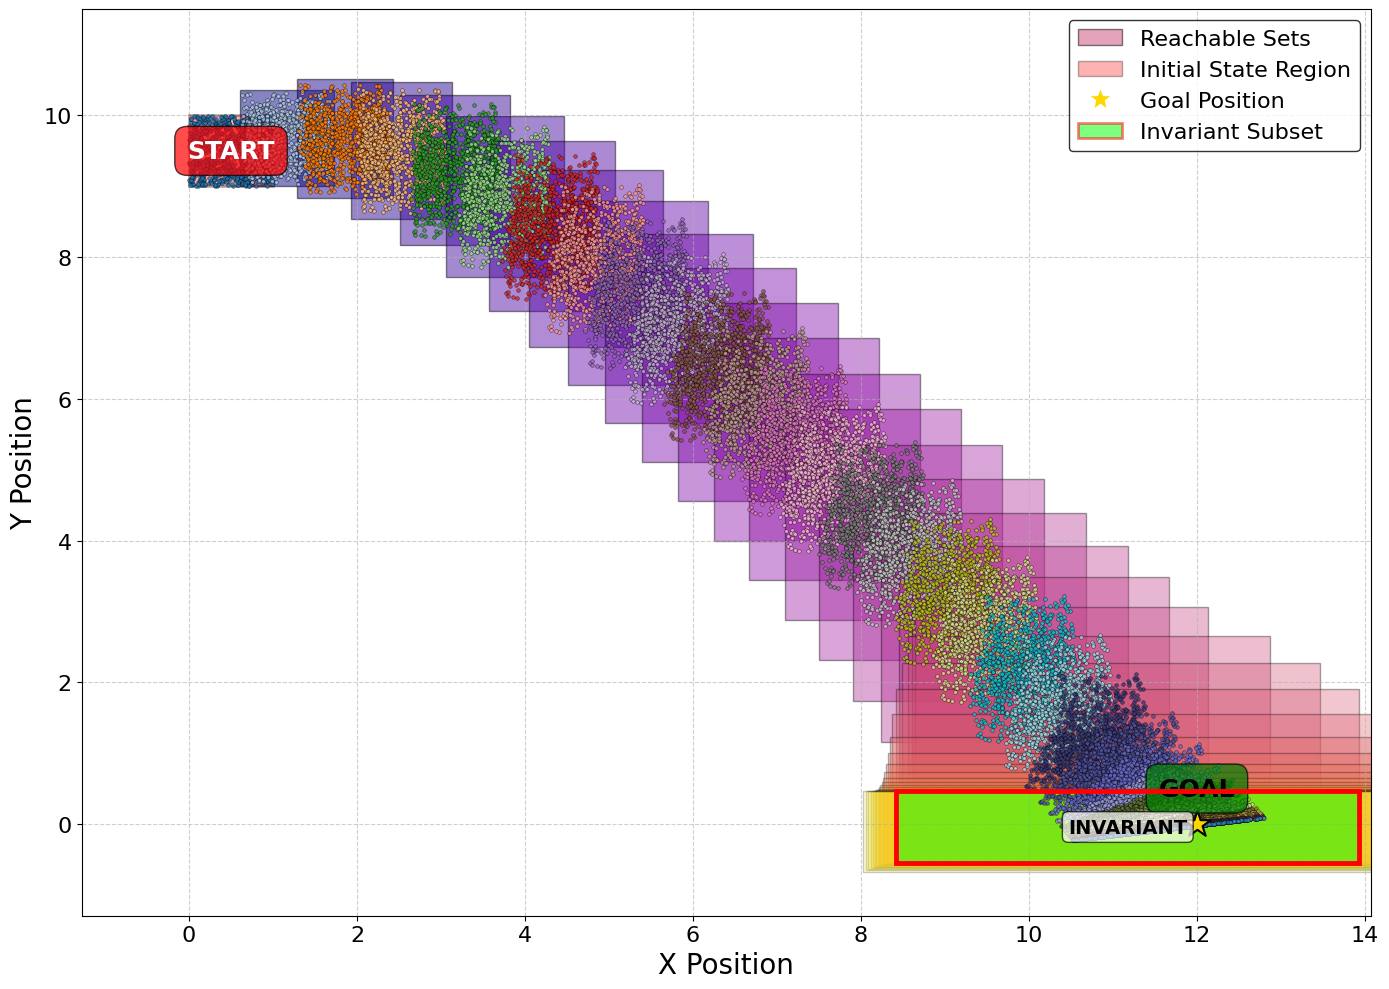

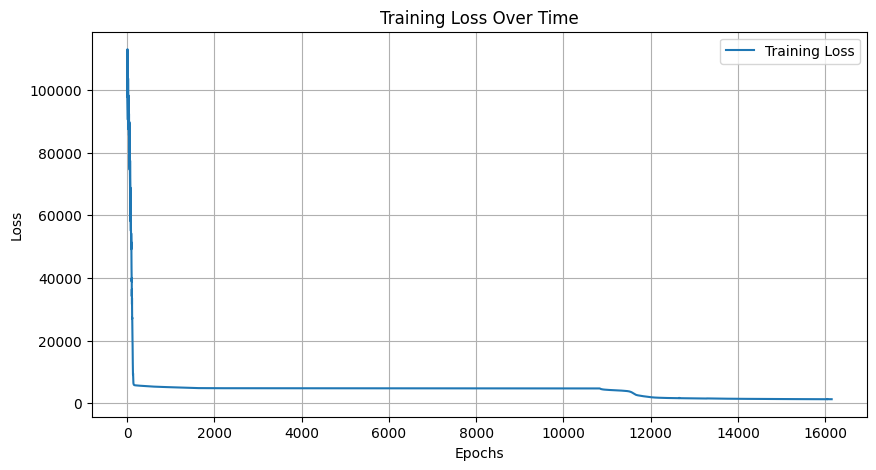

In [12]:
initial_state_range = np.array([
    [0,   1],
    [9,  10],
    [0, np.pi/6]
])

grid_size = 13
cost_map = np.ones((grid_size, grid_size))

danger_zones = [(8,8), (4,4)]
for zone in danger_zones:
    cost_map[zone] = 10

goal_zone = (0, grid_size - 1)
cost_map[goal_zone] = 0

num_steps = 40
learning_rate = 0.0001
optimizer = optax.adam(learning_rate)
num_epochs = 200000

lambda_inv = 100.0
invariance_start_step = 22

print("Starting training with invariance penalty after step 22...")
trained_params, loss_history = train_controller(
    params, optimizer,
    jnp.array(initial_state_range),
    num_epochs, cost_map, num_steps,
    lambda_inv=lambda_inv,
    invariance_start_step=invariance_start_step
)
print("Training completed.")

print("Computing reachable sets using trained controller...")
output_ranges = compute_multistep_reachable_set(
    initial_state_range, step_1, trained_params, num_steps
)

print("Reachable set bounds (watch for convergence after step 22):")
for i, rng in enumerate(output_ranges, start=1):
    lower_xy = rng.lower[:2]
    upper_xy = rng.upper[:2]
    area_xy = (upper_xy[0] - lower_xy[0]) * (upper_xy[1] - lower_xy[1])
    invariance_marker = " *" if i > invariance_start_step else ""
    print(f"Step {i}{invariance_marker}: X range = [{lower_xy[0]:.3f}, {upper_xy[0]:.3f}], "
          f"Y range = [{lower_xy[1]:.3f}, {upper_xy[1]:.3f}], Area = {area_xy:.3f}")

print("\nAnalyzing results to find invariant subset:")
invariant_x_min, invariant_x_max, invariant_y_min, invariant_y_max = analyze_invariant_subset(
    output_ranges, invariance_start_step
)

print("\nPlotting reachable sets with highly visible invariant subset...")
plot_with_invariant_subset(
    initial_state_range,
    functools.partial(step_1, params=trained_params),
    num_steps,
    cost_map,
    invariant_x_min=invariant_x_min,
    invariant_x_max=invariant_x_max,
    invariant_y_min=invariant_y_min,
    invariant_y_max=invariant_y_max,
    bounds_list=output_ranges,
    invariance_start_step=invariance_start_step
)

plot_loss_history(loss_history)